In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_predict, StratifiedKFold, KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [4]:
df = pd.read_csv('ibm_emp_perf.csv')
len(df)

1470

In [5]:
df = pd.read_csv('ibm_emp_perf.csv')
df.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'PercentSalaryHike','MonthlyRate','DailyRate', 'HourlyRate','StandardHours'], axis="columns", inplace=True)

categorical_cols = df.select_dtypes(include=["object"]).columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# train = df.iloc[:1000]   # first 1000 rows
# test = df.iloc[1000:]  # remaining rows


In [87]:
X = df.drop("PerformanceRating", axis=1)  
y = df["PerformanceRating"]

In [7]:
X.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked', 'OverTime',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [8]:
df.corr(numeric_only=True)["PerformanceRating"].sort_values(ascending=False)

PerformanceRating           1.000000
YearsInCurrentRole          0.034986
DistanceFromHome            0.027110
YearsWithCurrManager        0.022827
YearsSinceLastPromotion     0.017896
TotalWorkingYears           0.006744
MaritalStatus               0.005207
OverTime                    0.004369
StockOptionLevel            0.003506
YearsAtCompany              0.003435
Attrition                   0.002889
WorkLifeBalance             0.002572
JobSatisfaction             0.002297
Age                         0.001904
EducationField             -0.005614
Gender                     -0.013859
NumCompaniesWorked         -0.014095
TrainingTimesLastYear      -0.015579
MonthlyIncome              -0.017120
JobLevel                   -0.021222
JobRole                    -0.024233
Education                  -0.024539
Department                 -0.024604
BusinessTravel             -0.026341
JobInvolvement             -0.029071
EnvironmentSatisfaction    -0.029548
RelationshipSatisfaction   -0.031351
N

In [9]:
from sklearn.model_selection import cross_val_score
rf = RandomForestRegressor(n_estimators=200, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
all_preds = np.zeros(len(y))
rmse_list = []
feature_importances = []
for train_idx, val_idx in cv.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = RandomForestRegressor(n_estimators=200, random_state=42)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_val)
            all_preds[val_idx] = y_pred

            rmse = rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            rmse_list.append(rmse)
            feature_importances.append(model.feature_importances_)

print("Cross-validation RMSE scores:", rmse_list)
print("Mean RMSE:", np.mean(rmse_list))


Cross-validation RMSE scores: [np.float64(0.36555928169774893), np.float64(0.3733481760290489), np.float64(0.3779583985313836), np.float64(0.3787175144910952), np.float64(0.3562411235318546)]
Mean RMSE: 0.37036489885622625


                     Feature  MeanImportance  StdImportance
14             MonthlyIncome        0.128528       0.005275
0                        Age        0.091776       0.002011
4           DistanceFromHome        0.078729       0.002110
19         TotalWorkingYears        0.061047       0.003781
22            YearsAtCompany        0.044582       0.002101
20     TrainingTimesLastYear        0.044510       0.002308
23        YearsInCurrentRole        0.044416       0.002435
15        NumCompaniesWorked        0.042803       0.002480
24   YearsSinceLastPromotion        0.041940       0.002215
25      YearsWithCurrManager        0.039428       0.001435
11                   JobRole        0.037929       0.001541
5                  Education        0.036693       0.000813
17  RelationshipSatisfaction        0.033346       0.001520
12           JobSatisfaction        0.032109       0.001631
6             EducationField        0.031489       0.002906
7    EnvironmentSatisfaction        0.03

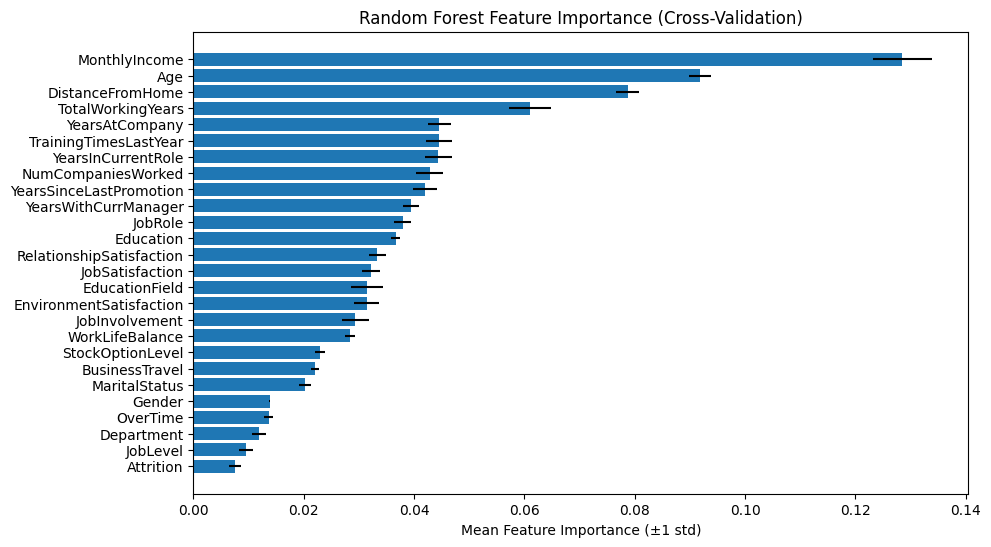

In [10]:
feature_importances = np.array(feature_importances)
mean_importance = feature_importances.mean(axis=0)
std_importance = feature_importances.std(axis=0)

feat_imp_cv = pd.DataFrame({
    "Feature": X.columns,
    "MeanImportance": mean_importance,
    "StdImportance": std_importance
}).sort_values("MeanImportance", ascending=False)

print(feat_imp_cv)

# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_imp_cv["Feature"], feat_imp_cv["MeanImportance"],
         xerr=feat_imp_cv["StdImportance"])
plt.gca().invert_yaxis()
plt.xlabel("Mean Feature Importance (±1 std)")
plt.title("Random Forest Feature Importance (Cross-Validation)")
plt.show()


In [11]:
df.PerformanceRating.value_counts()

PerformanceRating
3    1244
4     226
Name: count, dtype: int64

## Features Proxy (for f(features))

In [12]:
def pca_weighted_score(scaled_df, features):
    """
    use PCA to determine weights for given features and compute a weighted score
    """
    
    pca = PCA(n_components=1)
    pca.fit(scaled_df[features])
    
    # use absolute values of loadings as weights
    loadings = np.abs(pca.components_[0])
    weights = loadings / loadings.sum()
    
    # calculate weighted score
    scores = scaled_df[features].values @ weights
    return scores * 100, dict(zip(features, weights))

def init_states(df):
    """
    Calculate features parameters: Skill, Motivation, Fatigue
    """
    # Skill proxies
    skill_features = ["Education", "JobLevel", "TotalWorkingYears", 
                      "TrainingTimesLastYear", "YearsInCurrentRole"]
    
    # Motivation proxies
    motivation_features = ["JobSatisfaction", "EnvironmentSatisfaction", 
                           "RelationshipSatisfaction", "JobInvolvement", "WorkLifeBalance"]
    
    # Fatigue proxies
    fatigue_features = ["OverTime", "DistanceFromHome", 
                        "YearsSinceLastPromotion", "Age", "YearsWithCurrManager"]
    
    all_features = skill_features + motivation_features + fatigue_features
    scaler = MinMaxScaler()
    scaled_all = scaler.fit_transform(df[all_features])
    scaled_df = pd.DataFrame(scaled_all, columns=all_features, index=df.index)
    
    # pca weighted scores for each parameter
    skill, skill_w = pca_weighted_score(scaled_df, skill_features)
    motivation, motivation_w = pca_weighted_score(scaled_df, motivation_features)
    fatigue, fatigue_w = pca_weighted_score(scaled_df, fatigue_features)
    
    # return results and weights
    states = pd.DataFrame({
        "Skill": skill,
        "Motivation": motivation,
        "Fatigue": fatigue
    }, index=df.index)
    
    weights = {
        "Skill": skill_w,
        "Motivation": motivation_w,
        "Fatigue": fatigue_w
    }
    
    return states, weights

## Nudging Iteration

### With double For-loop

In [13]:
def nudging_iteration(X, y, X_states, n_rounds=5, n_splits=5):
    """
    Run iterative nudging simulation.
    - X: Training features
    - X_states: DataFrame with Skill, Motivation, Fatigue
    - y: ground truth labels
    - n_rounds: number of iterations
    - n_splits: number of CV splits for baseline prediction
    """
    current_y = y.copy()
    results = []
    
    for t in range(n_rounds):
        # baseline prediction with CV
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        all_preds = np.zeros(len(current_y))
        rmses = []
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = current_y.iloc[train_idx], current_y.iloc[val_idx]

            rf = RandomForestRegressor(n_estimators=200, random_state=42)
            rf.fit(X_train, y_train)

            y_pred_val = rf.predict(X_val)
            all_preds[val_idx] = y_pred_val

            # RMSE
            mse = mean_squared_error(y_val, y_pred_val)
            rmses.append(np.sqrt(mse))

        residuals = current_y.values - all_preds
        sigma = np.std(residuals)
        mean_rmse = np.mean(rmses)

        # fit linear regression to estimate f(features)
        X_fit = pd.DataFrame({
        "Skill": X_states["Skill"].values,
        "Motivation": X_states["Motivation"].values,
        "NegFatigue": -X_states["Fatigue"].values,   # take the negative of Fatigue
        }, index=X_states.index)
    
        reg = LinearRegression()
        reg.fit(X_fit, current_y)

        X_pred = X_fit.copy()
        f_values = reg.predict(X_pred)
        f_centered = f_values - f_values.mean()
        
        # do(N)
        do_N = np.random.normal(loc=f_centered, scale=sigma)
        
        # nudge rating
        direction = np.sign(all_preds - current_y)  # directional nudging
        do_N = np.abs(do_N) * direction
        nudge_rating = current_y + do_N
        # nudge_rating = np.clip(np.round(nudge_rating), 1, 4)

        current_y = pd.Series(nudge_rating, index=y.index)

        # distances
        results.append({
            "round": t+1,
            "cv_rmse": mean_rmse,
            "mean_dist_nudge": np.mean(np.abs(current_y - all_preds)),
            "mean_dist_true": np.mean(np.abs(y - all_preds)),
            "mean_current_y": current_y.mean(),
            "mean_all_preds": all_preds.mean()
        })
        
        print(f"[Round {t+1}] CV RMSE={mean_rmse:.4f}, "
              f"mean nudged_y={current_y.mean():.3f}, "
              f"dist to preds={np.mean(np.abs(current_y - all_preds)):.4f}")
        
    # save the final model if needed
    final_model = RandomForestRegressor(n_estimators=200, random_state=42)
    final_model.fit(X, current_y)

    return results, current_y, final_model

### With cross-val-predict

In [ ]:
def nudging_iteration(X, y, X_states, n_rounds=5, n_splits=5):
    """
    Run iterative nudging simulation.
    - X: Training features
    - X_states: DataFrame with Skill, Motivation, Fatigue
    - y: ground truth labels
    - n_rounds: number of iterations
    - n_splits: number of CV splits for baseline prediction
    """
    current_y = y.copy()
    results = []
    individual = []
    
    for t in range(n_rounds):
        # baseline prediction with CV
        rf = RandomForestRegressor(n_estimators=200, random_state=42)
        all_preds = cross_val_predict(rf, X, current_y, cv=n_splits)
        
        
        # CV RMSE
        mse = mean_squared_error(current_y, all_preds)
        mean_rmse = np.sqrt(mse)


        residuals = current_y.values - all_preds
        sigma = np.std(residuals)

        # fit linear regression to estimate f(features)
        X_fit = pd.DataFrame({
        "Skill": X_states["Skill"].values,
        "Motivation": X_states["Motivation"].values,
        "NegFatigue": -X_states["Fatigue"].values,   # take the negative of Fatigue
        }, index=X_states.index)
    
        reg = LinearRegression()
        reg.fit(X_fit, current_y)

        X_pred = X_fit.copy()
        f_values = reg.predict(X_pred)
        f_centered = f_values - f_values.mean()
        
        # do(N)
        do_N = np.random.normal(loc=f_centered, scale=sigma)
        
        # nudge rating
        direction = np.sign(all_preds - current_y)  # directional nudging
        do_N = np.abs(do_N) * direction
        nudge_rating = current_y + do_N
        # nudge_rating = np.clip(np.round(nudge_rating), 1, 4)

        current_y = pd.Series(nudge_rating, index=y.index)
        individual.append(current_y[0])

        # distances
        results.append({
            "round": t+1,
            "cv_rmse": mean_rmse,
            "mean_dist_nudge": np.mean(np.abs(current_y - all_preds)),
            "mean_dist_true": np.mean(np.abs(y - all_preds)),
            "mean_current_y": current_y.mean(),
            "mean_all_preds": all_preds.mean()
        })

        
        print(f"[Round {t+1}] CV RMSE={mean_rmse:.4f}, "
              f"mean nudged_y={current_y.mean():.3f}, "
              f"dist to preds={np.mean(np.abs(current_y - all_preds)):.4f}")
        
    # save the final model if needed
    final_model = RandomForestRegressor(n_estimators=200, random_state=42)
    final_model.fit(X, current_y)

    return results, current_y, final_model, individual

In [149]:
def nudging_iteration(X, y, X_states, n_rounds=5, n_splits=5, plot_each_round=False):
    """
    Run iterative nudging simulation.
    - X: Training features
    - X_states: DataFrame with Skill, Motivation, Fatigue
    - y: ground truth labels
    - n_rounds: number of iterations
    - n_splits: number of CV splits for baseline prediction
    """
    current_y = y.copy()
    results = []
    pred_history = []
    individual = []
    f_values_his = []
    nudged_history = []
    f_values_baseline = None
    
    for t in range(n_rounds):
        # baseline prediction with CV
        rf = RandomForestRegressor(n_estimators=200, random_state=42)
        all_preds = cross_val_predict(rf, X, current_y, cv=n_splits)
        pred_history.append(all_preds.copy())
        
        
        # CV RMSE
        mse = mean_squared_error(current_y, all_preds)
        mean_rmse = np.sqrt(mse)


        residuals = current_y.values - all_preds
        sigma = np.std(residuals)

        # fit linear regression to estimate f(features)
        X_fit = pd.DataFrame({
        "Skill": X_states["Skill"].values,
        "Motivation": X_states["Motivation"].values,
        "NegFatigue": -X_states["Fatigue"].values,   # take the negative of Fatigue
        }, index=X_states.index)
    
        reg = LinearRegression()
        reg.fit(X_fit, current_y)

        X_pred = X_fit.copy()
        f_values = reg.predict(X_pred)
        if f_values_baseline is None:
            f_values_baseline = f_values.copy()
        f_centered = f_values - f_values.mean()
        f_values_his.append(f_values.copy())
        
        # do(N)
        do_N = np.random.normal(loc=f_centered, scale=sigma)
        
        # nudge rating
        direction = np.sign(all_preds - current_y)  # directional nudging
        do_N = np.abs(do_N) * direction
        nudge_rating = current_y + do_N
        # nudge_rating = np.clip(np.round(nudge_rating), 1, 4)

        current_y = pd.Series(nudge_rating, index=y.index)
        nudged_history.append(current_y.copy())

        # distances
        results.append({
            "round": t+1,
            "cv_rmse": mean_rmse,
            "mean_dist_nudge": np.mean(np.abs(current_y - all_preds)),
            "mean_dist_true": np.mean(np.abs(y - all_preds)),
            "mean_current_y": current_y.mean(),
            "mean_all_preds": all_preds.mean()
        })

        
        print(f"[Round {t+1}] CV RMSE={mean_rmse:.4f}, "
              f"mean nudged_y={current_y.mean():.3f}, "
              f"dist to preds={np.mean(np.abs(current_y - all_preds)):.4f}")
        
        
        if plot_each_round:
            sort_idx = np.argsort(f_values)
            plt.figure(figsize=(8,6))
            plt.scatter(f_values_baseline[sort_idx], y.iloc[sort_idx], color="grey", alpha=0.5, label="Original y")
            plt.scatter(f_values[sort_idx], current_y.iloc[sort_idx], color="red", alpha=0.5, label=f"Nudged y (round {t+1})")
            plt.scatter(f_values[sort_idx], all_preds[sort_idx], color="blue", alpha=0.5, label=f"Prediction (round {t+1})")
            plt.xlabel("f_value")
            plt.ylabel("Outcome / Prediction")
            plt.title(f"Nudging Iteration {t+1}")
            plt.legend()
            plt.grid(True)
            plt.show()
        
    # save the final model if needed
    final_model = RandomForestRegressor(n_estimators=200, random_state=42)
    final_model.fit(X, current_y)

    return results, current_y, final_model, f_values_his, pred_history, nudged_history

In [127]:
def no_nudging_iteration(X, y, X_states, n_rounds=5, n_splits=5, plot_each_round=False):
    """
    Baseline simulation without nudging (y is fixed).
    - X: Training features
    - y: ground truth labels
    - X_states: DataFrame with Skill, Motivation, Fatigue
    """
    results = []
    pred_history = []
    f_values_his = []

    for t in range(n_rounds):
        # baseline prediction with CV
        rf = RandomForestRegressor(n_estimators=200, random_state=42)
        all_preds = cross_val_predict(rf, X, y, cv=n_splits)
        pred_history.append(all_preds.copy())

        # CV RMSE
        mse = mean_squared_error(y, all_preds)
        mean_rmse = np.sqrt(mse)

        # fit linear regression to estimate f(features)
        X_fit = pd.DataFrame({
            "Skill": X_states["Skill"].values,
            "Motivation": X_states["Motivation"].values,
            "NegFatigue": -X_states["Fatigue"].values,
        }, index=X_states.index)
        reg = LinearRegression()
        reg.fit(X_fit, y)

        f_values = reg.predict(X_fit)
        f_values_his.append(f_values.copy())

        results.append({
            "round": t+1,
            "cv_rmse": mean_rmse,
            "mean_dist_true": np.mean(np.abs(y - all_preds)),
            "mean_y": y.mean(),
            "mean_preds": all_preds.mean()
        })

        print(f"[Round {t+1}] CV RMSE={mean_rmse:.4f}, "
              f"mean y={y.mean():.3f}, "
              f"dist to preds={np.mean(np.abs(y - all_preds)):.4f}")

        if plot_each_round:
            sort_idx = np.argsort(f_values)
            plt.figure(figsize=(8,6))
            plt.scatter(f_values[sort_idx], y.iloc[sort_idx], 
                        color="grey", alpha=0.5, label="Original y")
            plt.scatter(f_values[sort_idx], all_preds[sort_idx], 
                        color="blue", alpha=0.5, label=f"Prediction (round {t+1})")
            # plt.plot(f_values[sort_idx], f_values[sort_idx], "k--", label="f_value baseline")  
            plt.xlabel("f_value")
            plt.ylabel("Outcome / Prediction")
            plt.title(f"No-Nudging Iteration {t+1}")
            plt.legend()
            plt.grid(True)
            plt.show()

    # save the final model
    final_model = RandomForestRegressor(n_estimators=200, random_state=42)
    final_model.fit(X, y)

    return results, y, final_model, f_values_his, pred_history


## Iteration

[Round 1] CV RMSE=0.3748, mean nudged_y=3.365, dist to preds=0.2524


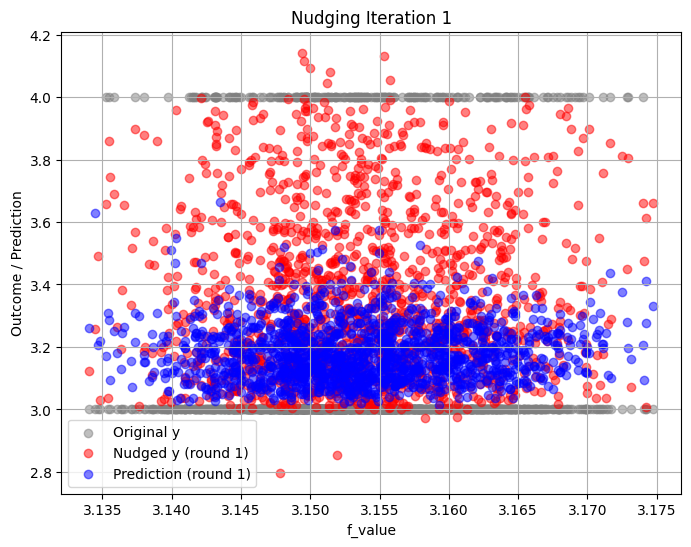

[Round 2] CV RMSE=0.2716, mean nudged_y=3.400, dist to preds=0.1782


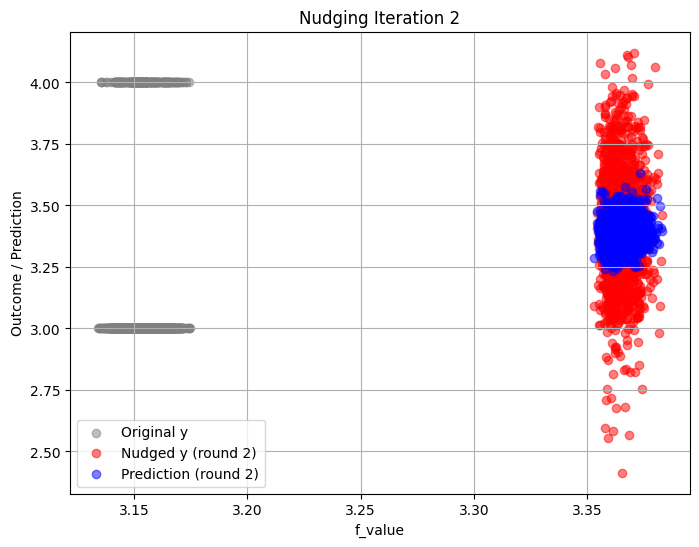

[Round 3] CV RMSE=0.2306, mean nudged_y=3.415, dist to preds=0.1561


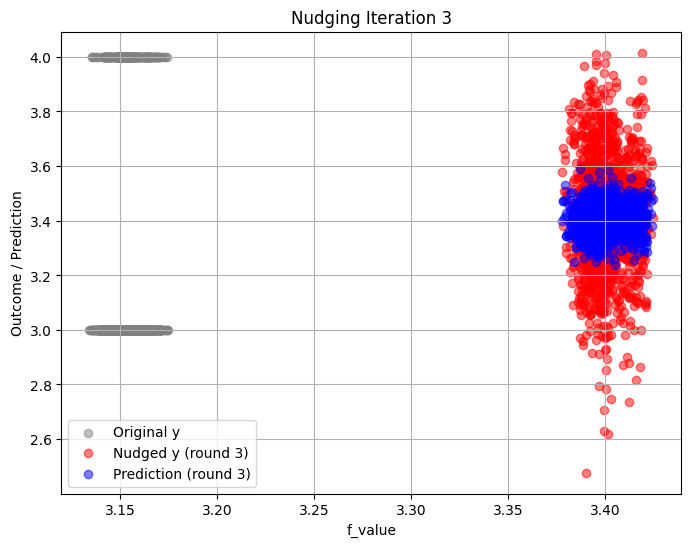

[Round 4] CV RMSE=0.2043, mean nudged_y=3.413, dist to preds=0.1371


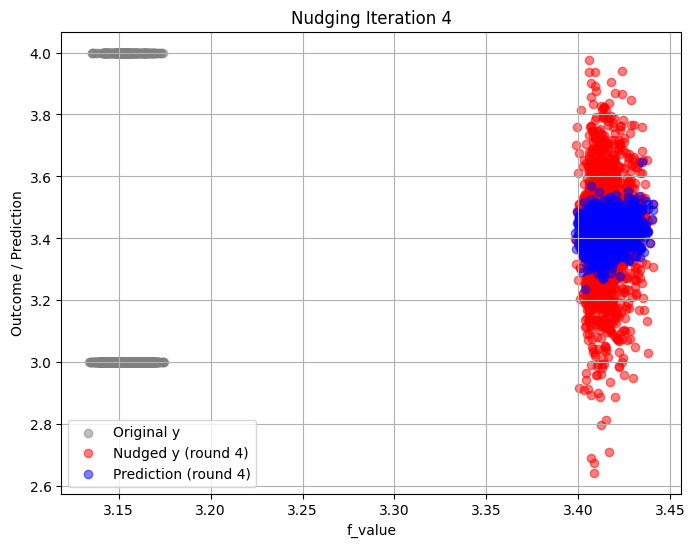

[Round 5] CV RMSE=0.1844, mean nudged_y=3.411, dist to preds=0.1254


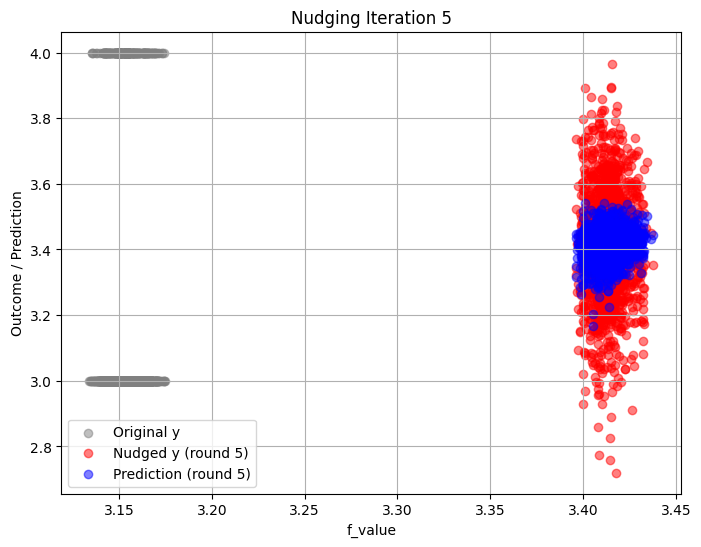

[Round 6] CV RMSE=0.1680, mean nudged_y=3.411, dist to preds=0.1127


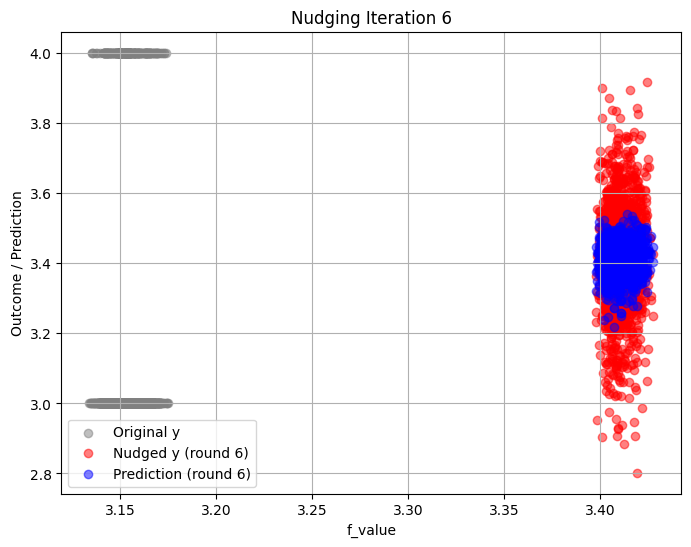

[Round 7] CV RMSE=0.1481, mean nudged_y=3.407, dist to preds=0.1011


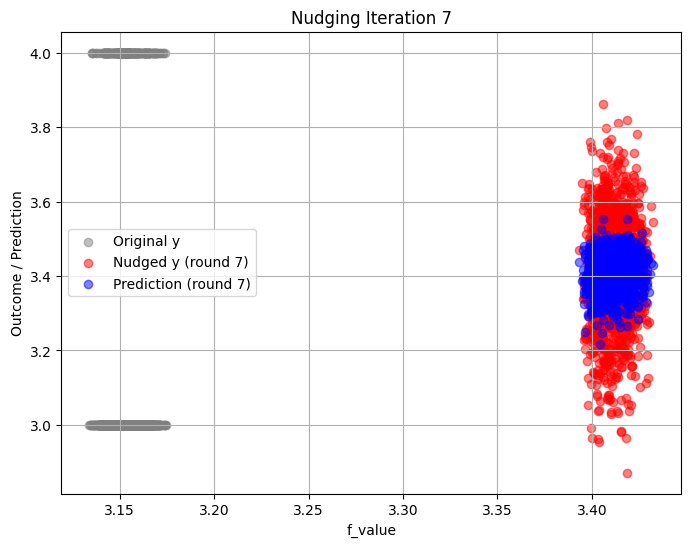

[Round 8] CV RMSE=0.1343, mean nudged_y=3.404, dist to preds=0.0907


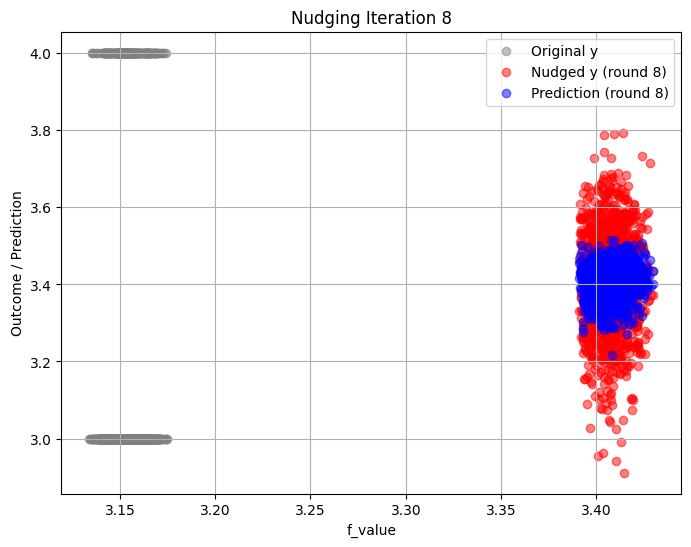

[Round 9] CV RMSE=0.1180, mean nudged_y=3.405, dist to preds=0.0792


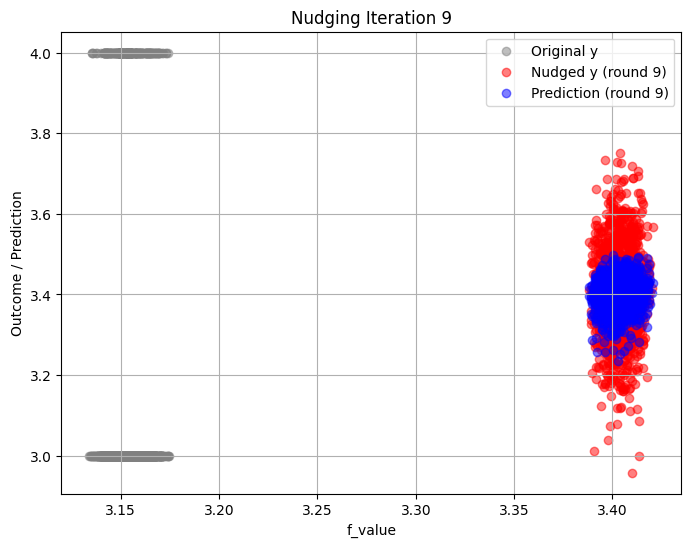

[Round 10] CV RMSE=0.1036, mean nudged_y=3.405, dist to preds=0.0682


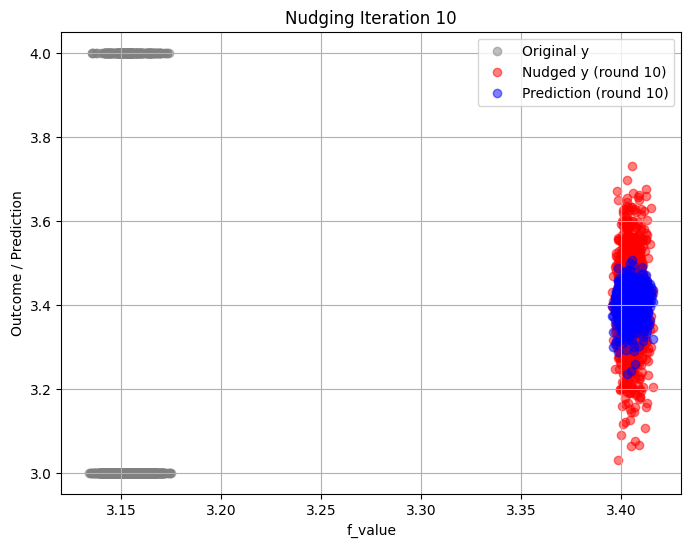

In [151]:
# initialization
test_agents = X.copy()
states, weights = init_states(test_agents)
X_states = states[["Skill", "Motivation", "Fatigue"]]

# 10 iterations
results, nudged_y, final_model, f_values_his,  pred_history, nudged_history = nudging_iteration(X, y, X_states, n_rounds=10, n_splits=5, plot_each_round=True)

[Round 1] CV RMSE=0.3748, mean y=3.154, dist to preds=0.2803


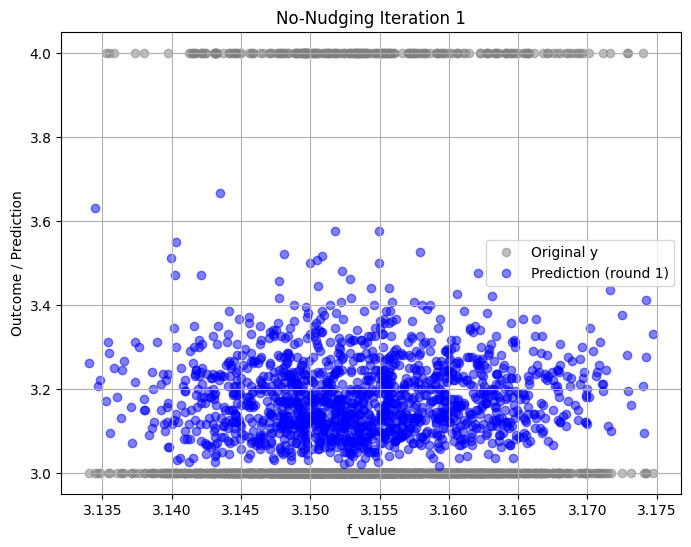

In [129]:
results_non, y_non, final_model_non, f_values_his_non, pred_history_non = no_nudging_iteration(X, y,X_states, n_rounds=1, n_splits=5, plot_each_round=True)

In [159]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

def animate_nudging(y, nudged_history, pred_history, f_values_his, save_path=None):
    fig, ax = plt.subplots(figsize=(7, 6))
    # calculate global ranges across all frames
    all_fvals = np.concatenate([np.asarray(f).ravel() for f in f_values_his])
    span = max(all_fvals) - min(all_fvals)
    all_y_values = np.concatenate([np.asarray(y).ravel(), 
                                   np.concatenate([np.asarray(p).ravel() for p in pred_history]),
                                   np.concatenate([np.asarray(n).ravel() for n in nudged_history])])
    
    ax.set_xlim(min(all_fvals) - 0.01, max(all_fvals) + 0.01)
    # ax.set_xlim(3.1, 3.2)
    ax.set_ylim(min(all_y_values) - 0.01, max(all_y_values) + 0.01)

    fvals_baseline = np.asarray(f_values_his[0]).ravel()
    scat_true = ax.scatter(f_values_his[0], y, color="grey", alpha=0.5, label="Original y")
    scat_nudge = ax.scatter(f_values_his[0], nudged_history[0], color="red", alpha=0.5, label="Nudged y")
    scat_pred = ax.scatter(f_values_his[0], pred_history[0], color="blue", alpha=0.5, label="Prediction")
    ax.legend()
    ax.set_xlabel("f_value")
    ax.set_ylabel("Performance Rating") 

    def update(frame):
        ax.set_title(f"Nudging Iteration {frame+1}")
        preds = np.asarray(pred_history[frame]).ravel()
        nudged = np.asarray(nudged_history[frame]).ravel()
        f_vals = np.asarray(f_values_his[frame]).ravel()
        
        offsets_true = np.c_[fvals_baseline, np.asarray(y).ravel()]
        offsets_pred = np.c_[f_vals, preds]
        offsets_nudge = np.c_[f_vals, nudged]

                
        scat_true.set_offsets(offsets_true)
        scat_pred.set_offsets(offsets_pred)
        scat_nudge.set_offsets(offsets_nudge)
        return scat_true, scat_nudge, scat_pred
    ani = animation.FuncAnimation(fig, update, len(nudged_history), interval=1000, blit=True)
    if save_path:
        ani.save(save_path, writer="pillow" if save_path.endswith(".gif") else "ffmpeg")
    else:
        plt.show()

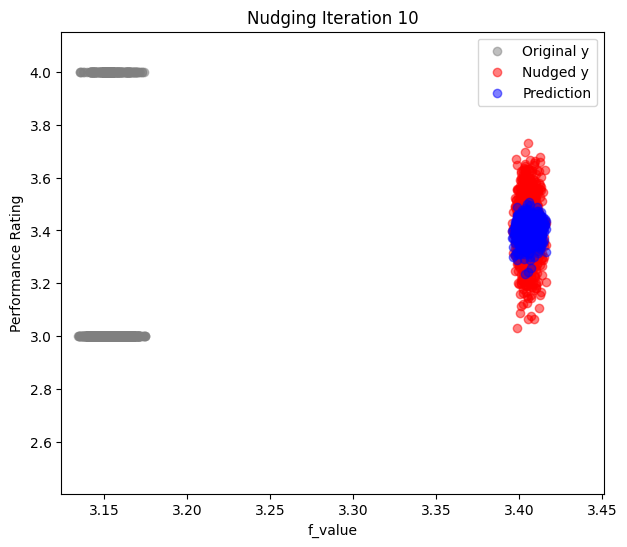

In [160]:
animate_nudging(y, nudged_history, pred_history, f_values_his, save_path="nudging.gif")

In [21]:
X_states

,Skill,Motivation,Fatigue
0,22.730275,63.664013,94.208633
1,25.229106,54.059710,2.720751
2,8.309232,66.771641,93.478472
3,21.797599,73.803026,93.620786
4,6.955305,40.383834,0.797938
...,...,...,...
1465,27.575762,85.708166,3.037952
1466,35.357225,23.447786,2.196188
1467,22.024128,35.247952,93.730701
1468,34.497837,60.475136,2.246507


In [20]:
individual

[np.float64(3.0572282445276677),
 np.float64(3.454746345541983),
 np.float64(3.4009556804390417),
 np.float64(3.528511939780102),
 np.float64(3.468304571230802),
 np.float64(3.3670061627733143),
 np.float64(3.3683267006696673),
 np.float64(3.4424113171280992),
 np.float64(3.470605769728536),
 np.float64(3.4112016051868856)]

In [19]:
results = pd.DataFrame(results)
results

,round,cv_rmse,mean_dist_nudge,mean_dist_true,mean_current_y,mean_all_preds
0,1,0.374796,0.247946,0.280276,3.357818,3.181167
1,2,0.270313,0.173649,0.408298,3.396353,3.368172
2,3,0.220866,0.143166,0.426140,3.402375,3.396098
3,4,0.192062,0.131409,0.428838,3.397886,3.400749
4,5,0.172311,0.117445,0.427418,3.397496,3.396943
5,6,0.156336,0.104576,0.429480,3.407177,3.398915
6,7,0.137966,0.093206,0.435171,3.407942,3.407274
7,8,0.123610,0.080501,0.436283,3.410243,3.408129
8,9,0.106847,0.073452,0.437401,3.406483,3.409529
9,10,0.097971,0.067178,0.435871,3.409568,3.407782


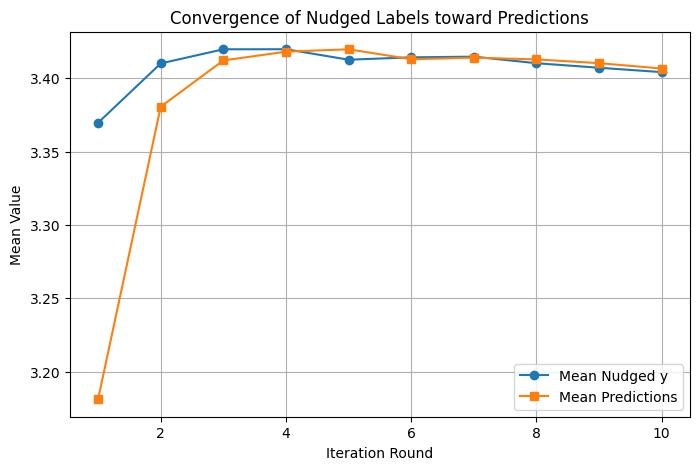

In [55]:
plt.figure(figsize=(8,5))
plt.plot(results["round"], results["mean_current_y"], marker="o", label="Mean Nudged y")
plt.plot(results["round"], results["mean_all_preds"], marker="s", label="Mean Predictions")

plt.xlabel("Iteration Round")
plt.ylabel("Mean Value")
plt.title("Convergence of Nudged Labels toward Predictions")
plt.legend()
plt.grid(True)
plt.show()

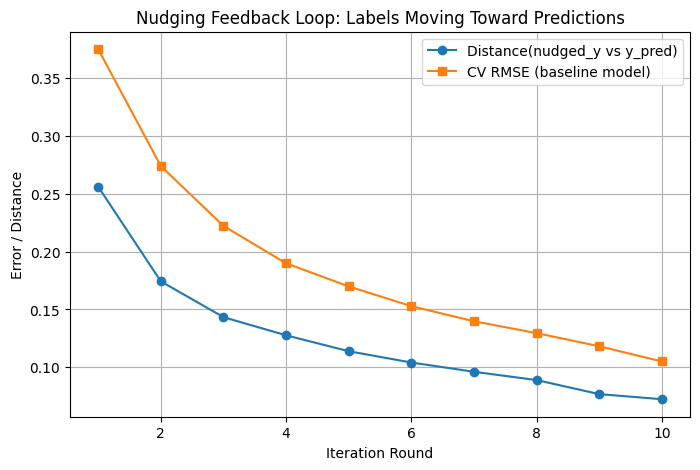

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

df_results = pd.DataFrame(results)

plt.figure(figsize=(8,5))
plt.plot(df_results["round"], df_results["mean_dist_nudge"], marker="o", label="Distance(nudged_y vs y_pred)")
plt.plot(df_results["round"], df_results["cv_rmse"], marker="s", label="CV RMSE (baseline model)")

plt.xlabel("Iteration Round")
plt.ylabel("Error / Distance")
plt.title("Nudging Feedback Loop: Labels Moving Toward Predictions")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def plot_rf_with_nudging(X, y, nudged_y, feature_name, model):
    """
    畫出 RF 預測曲線 + 原始 y 和 nudged_y 分布
    - X: 特徵 DataFrame
    - y: 原始 labels (Series)
    - nudged_y: nudged 過的 labels (Series)
    - feature_name: 要排序並畫圖的特徵名稱 (str)
    - model: 已經 fit 好的 RandomForestRegressor
    """
    # === Step 1. 排序 X ===
    sort_idx = np.argsort(X[feature_name].values)
    X_sorted = X.iloc[sort_idx]
    y_sorted = y.iloc[sort_idx]
    nudged_sorted = nudged_y.iloc[sort_idx]

    # === Step 2. RF 預測 ===
    y_pred_sorted = model.predict(X_sorted)

    # === Step 3. 畫圖 ===
    plt.figure(figsize=(10,6))

    # RF 預測平滑曲線
    plt.plot(X_sorted[feature_name], y_pred_sorted, color="black", label="RF Prediction", linewidth=2)

    # 原始 y 分布
    plt.scatter(X_sorted[feature_name], y_sorted, color="grey", alpha=0.6, label="Original y")

    # Nudged y 分布
    plt.scatter(X_sorted[feature_name], nudged_sorted, color="red", alpha=0.6, label="Nudged y")

    plt.xlabel(feature_name)
    plt.ylabel("Risk Score / Outcome")
    plt.title(f"Random Forest Prediction vs Original/Nudged Labels ({feature_name})")
    plt.legend()
    plt.grid(True)
    plt.show()
